In [6]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

# A primer on data-driven dimension reduction

Many physical systems are high dimensional, which can make it challenging to obtain approximations of them, and it often even more challenging to visualise these approximations. However, all is not lost! Many seemingly high-dimensional systems have intrinsically low-dimensional structure. Although the quantity of interest $f(\mathbf{x})$ might be defined as a function of a large set of parameters $\mathbf{x} \in \mathbb{R}^d$, its variation can often be approximately captured with a small number of linear projections of the original parameters $\mathbf{W}^T \mathbf{x} \in \mathbb{R}^n$. Here, $n \ll d$ and $\mathbf{W} \in \mathbb{R}^{d\times n}$ is a tall matrix whose column span is called the *dimension reducing subspace*, or *active subspace*. 

In other words, we assume that our quantities of interest are well--approximated by *ridge functions*,

$$f(\mathbf{x}) \approx g(\mathbf{W}^T \mathbf{x}),$$

where $g:\mathbb{R}^n \rightarrow \mathbb{R}$ is a low-dimensional non-linear function called the *ridge profile*. The intuitive computational advantage behind *ridge approximations* is that instead of estimating a function in $\mathbb{R}^d$, we approximate it in $\mathbb{R}^n$, which also facilitates easy visualisation. In figure b) below, a ridge approximation is obtained for a turbo-machinery dataset \[1], demonstrating how a low dimensional approximation can be obtained with a suitable $\mathbf{W}$ matrix.

The *equadratures* code uses orthogonal polynomials to represent $g$, and so identifying ridge functions consists of computing coefficients for $g$ as well as identifying a suitable subspace matrix $\mathbf{W}$. Two techniques are avaiable for this in the code, *active subspaces* and *variable projection*.

## Dimension reduction for a fan blade

To provide a brief demononstration, we take a dataset from this [Journal of Turbomachinery paper](https://doi.org/10.1115/1.4038839). A turbomachinery fan blade is parameterised by $\mathbf{x} \in \mathbb{R}^{25}$, and the Quantity of Interest (QoI) is the efficiency $\eta=f(\mathbf{x})$ of the fan blade. The task here is to find a subspace matrix $\mathbf{W} \in \mathbb{R}^{25\times 1}$, so that the $f(\mathbf{x})$ can be approximated over a dimension reducing subspace $u=\mathbf{W}^T \mathbf{x}$, where $u \in \mathbb{R}^1$.

In [2]:
import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
import equadratures as eq

data = eq.datasets.load_eq_dataset('3Dfan_blades',verbose=False)
X  = data['X_a']
y = data['y1_a']

Before using equadratures, lets see what happens when the subspace is formed from an equal contribution of all 25 design parameters, by setting $\mathbf{W} = \frac{\mathbf{1}}{\sqrt{25}}$.

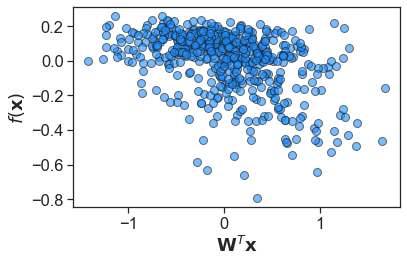

In [3]:
Wequal = np.ones([25,1])/np.sqrt(25)
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlabel(r'$\mathbf{W}^T\mathbf{x}$')
ax.set_ylabel(r'$f(\mathbf{x})$')
plt.plot(X@Wequal,y,'o',ms=8,c='dodgerblue',mec='k',alpha=0.6)
plt.show(1)

Clearly, taking an equal contribution of all parameters isn't effective here. The training samples are rather scattered over the subspace, and we're unable to fit a ridge approximation $f(\mathbf{x}) \approx g(\mathbf{W}^T \mathbf{x})$ which effectively describes the variation in $f(\mathbf{x})$.

Instead, lets try the obtain a 1D dimension reducing subspace with the `Subspaces` module. We use `method='variable-projection'` here, where the non-linear least squares problem

$$
\underset{\mathbf{W}, \boldsymbol{\alpha}}{\text{minimize}} \; \; \left\Vert f\left(\mathbf{x}\right)-g_{\boldsymbol{\alpha}}\left(\mathbf{W}^{T} \mathbf{x}\right)\right\Vert _{2}^{2}
$$

is solved by recasting it as a separable non-linear least squares problem. Here, Gauss-Newton optimization used to solve for the polynomial coefficients $\alpha$ and subspace matrix $\mathbf{W}$ together. After computing the `Subspace`, we could generate the below plot in one line using `plot_sufficient_summary()`, but here we'll do it manually to expose the inner workings.

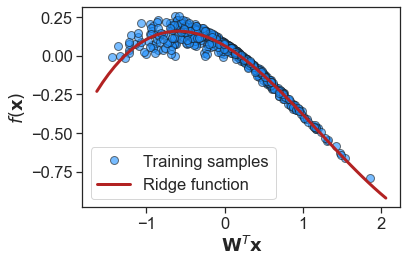

In [4]:
# Apply variable projection
subdim = 1
subspace = eq.Subspaces(method='variable-projection',sample_points=X,
                            sample_outputs=y,polynomial_degree=3, subspace_dimension=subdim)
Wvp = subspace.get_subspace()[:,0:subdim]
u = (X@Wvp).reshape(-1,1)
subpoly = subspace.get_subspace_polynomial()

# Plot the resulting subspace
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlabel(r'$\mathbf{W}^T\mathbf{x}$')
ax.set_ylabel(r'$f(\mathbf{x})$')
u_vp = X@Wvp
ax.plot(u_vp,y,'o',ms=8,c='dodgerblue',mec='k',alpha=0.6,label='Training samples')
u_to_plot = np.linspace(u_vp.min()-0.2,u_vp.max()+0.2,50)
ax.plot(u_to_plot,subpoly.get_polyfit(u_to_plot),lw=3,c='firebrick',label='Ridge function')
ax.legend()
plt.show()

Much better! We now have a one-dimensional subspace, formed from a linear combination of the 25 design parameters, which is able to describe the variation in the fan efficiency, $f=\eta$. As we will see in later tutorials, such subspaces can be used for design space exploration, physics investigation, and even flowfield estimation!